# Text classification - Instacart Dataset

In [2]:
from huggingface_hub import login
# login('xxxx', add_to_git_credential=True)


In [1]:
import numpy as np
from datasets import load_dataset
# from datasets import Dataset
from datasets import DatasetDict
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments
import transformers
import re
import torch
from torch import nn
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score
import datetime


from create_set import create_dataset, create_number_labs


In [2]:
df_csv = pd.read_csv('../scrape/test_food_bev_alc.csv')
unq_id = df_csv.typeID.unique()
print([fnc(unq_id) for fnc in [len, max]])
df_csv.drop(columns=['typeID', 'link'], inplace=True)
df_csv.rename(columns={"product": "text"}, inplace=True)
df_csv.head()

[2244, 2327]


,text,label
0,New Belgium Brewing Fat Tire Ale12 fl oz,alcohol/beer/ales/amber red ale
1,"Yuengling Beer, Traditional Lager, 24 Pack12 f...",alcohol/beer/ales/amber red ale
2,George Killian's Irish Red Lager Beer12 fl oz,alcohol/beer/ales/amber red ale
3,"Dragon's Milk Crimson Keep, Bourbon Barrel-Age...",alcohol/beer/ales/amber red ale
4,Smithwick's Red Ale Beer14.9 fl oz,alcohol/beer/ales/amber red ale


In [3]:
id_chk = create_number_labs(df_csv, 'label', 20)

In [4]:
print(df_csv.base_label.max())
df_csv.head()


7720000


,text,label,lab_0,lab_1,lab_2,lab_3,lab_4,lab_5,base_label
2007,Great Lakes Brewing Co. Christmas Ale Glaze14 ...,alcohol/alcohol making kits/beer making kits,0,0,0,0,0,0,160000
2008,BarkLogic Beer Line Cleaner1 L,alcohol/alcohol making kits/beer making kits,0,0,0,0,0,0,160000
2009,Ferment'n Home Fermentation Kit1 ct,alcohol/alcohol making kits/beer making kits,0,0,0,0,0,0,160000
2010,Shipyard Brewing Company Seasonal Beer in Bott...,alcohol/alcohol making kits/beer making kits,0,0,0,0,0,0,160000
2011,Canlzo Eco-Friendly Fireeach,alcohol/alcohol making kits/beer making kits,0,0,0,0,0,0,160000


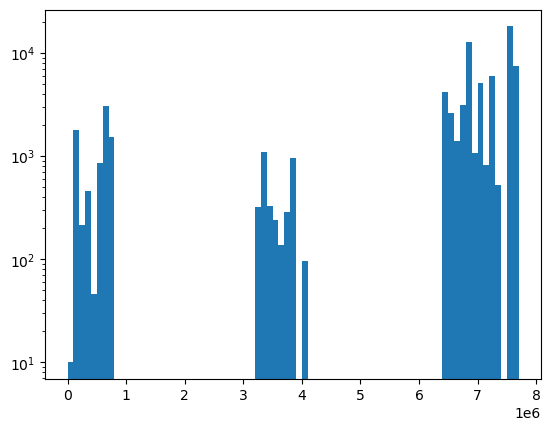

In [5]:
binw = 100000
plt.hist(df_csv.base_label, bins=np.arange(0, df_csv.base_label.max(), binw)-.5)
plt.yscale('log')

In [6]:
dset = create_dataset(df_csv)
df_csv['orig_lab'] = df_csv['label'].copy()
df_csv['label'] = df_csv['base_label'].copy().astype(float)
# [len(ddfs['product']) for ddfs in dict_dfs]
# len(dict_dfs)

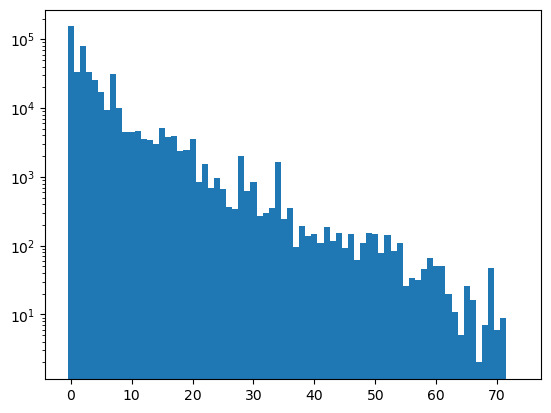

In [7]:
plt.hist(id_chk.label_array.flatten(), bins = np.arange(0, 75)-.5)
plt.yscale('log')

In [8]:
(df_csv['label'].max()-df_csv['label'].min())

7720000.0

In [9]:
# df_csv['label'] = ((df_csv['label']-df_csv['label'].min())*100000/(df_csv['label'].max()-df_csv['label'].min())).astype(int)
prod = dset.get_train_val_test([.9,.09,.01])


## Overview of Instacart Dataset

In [10]:
prod.set_format('pandas')
df = prod['train'][:]
df.sample(frac=1 ,random_state=1).head(10)

,text,label,lab_0,lab_1,lab_2,lab_3,lab_4,lab_5,base_label,orig_lab
58240,"House Foods Wasabi, Family Size2.8 oz",7642400.0,2,7,4,24,0,0,7642400,food/pantry/condiments/wasabi
15680,BelGioioso Provolone Cheese Sharp Wedge5 oz,6432800.0,2,1,0,51,0,0,6432800,food/dairy/cheese/provolone
37346,Mrs. T's Classic Cheddar16 oz,6899362.0,2,4,7,0,0,0,6899362,food/frozen food/frozen snacks/frozen dumplings
31865,Organic Turnip25 lb,6880900.0,2,3,1,28,25,0,6880900,food/fresh produce/fresh vegetables/root veget...
41514,Value Pack Pork Shoulder Bladeper lb,7056000.0,2,5,4,7,10,0,7056000,food/meat/pork/pork chop/pork shoulder blade s...
46265,Spice Supreme Cream Of Tartar2.25 oz,7368000.0,2,7,0,4,4,0,7368000,food/pantry/baking and cooking/baking powders/...
57260,"CJ Foods Soybean Paste, Ssamjang, Seasoned, Or...",7643600.0,2,7,4,20,22,1,7643600,food/pantry/condiments/sauces/pastes/bean paste
17448,So Delicious Vanilla Coconut Milk Yogurt Alter...,6579200.0,2,1,10,0,0,0,6579200,food/dairy/yogurt/dairy free yogurt
52733,Store Brand Halved Bartlett Pears in Pear Juic...,7570800.0,2,7,3,3,12,0,7570800,food/pantry/canned goods/canned fruit/canned p...
3886,Rondel Brut Cava187 ml,659200.0,0,4,1,0,0,0,659200,alcohol/wine/champagne and sparkling wine/cava


In [11]:
prod.reset_format()

In [12]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
EPOCHS = 1
LEARNING_RATE = 1e-04
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [13]:
use_mps = torch.backends.mps.is_available()
device = torch.device("mps" if use_mps else "cpu")

In [14]:
class PosModel(nn.Module):
    def __init__(self, num_labels, max_len, hidden_size=768):
        super(PosModel, self).__init__()
        
        self.base_model = AutoModel.from_pretrained('bert-base-cased')
        # self.dropout = nn.Dropout(0.8)
        # self.softmax = nn.Softmax(dim=1)
        # self.rnn = nn.RNN(hidden_size, max_len, 2)
        # self.linear = nn.Linear(max_len**2, num_labels) # output features from bert is 768 and 1 is our prediction
        self.linear = nn.Linear(hidden_size*max_len, num_labels) # output features from bert is 768 and 1 is our prediction
        bottom = range(2, 12)
        middle = list(range(0,5))+list(range(7,12))
        top = range(0, 10)
        layall = range(0, 12)
        
        layersToFreeze = layall
        for i in layersToFreeze:
          # print(i)
          for param in self.base_model.encoder.layer[i].parameters():
            param.requires_grad = False
        
    def forward(self, ids, attn_mask):
        outputs = self.base_model(ids, attention_mask=attn_mask)

        # print('op shape1:', outputs[0].shape)
        # You write you new head here
        # outputs = self.dropout(outputs[0])
        # print('op shape2:', outputs[0].shape)
        # outputs = self.linear(outputs.view(outputs.shape[0], -1))

        # outputs = self.softmax(outputs[0].view(outputs[0].shape[0], -1))
        # outputs = self.rnn(outputs[0])
        # outputs = self.softmax(outputs.view(outputs.shape[0], -1))
        outputs = self.linear(outputs[0].view(outputs[0].shape[0], -1))
        # outputs = self.linear(outputs)
        # print('op shape3:', outputs[0].shape)
        
        return outputs.flatten()

# model = PosModel()
# model.to('cuda')

In [15]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = dataframe.label
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'attn_mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [16]:
new_df = df_csv[['text', 'label']].copy()
new_df.head()

,text,label
2007,Great Lakes Brewing Co. Christmas Ale Glaze14 ...,160000.0
2008,BarkLogic Beer Line Cleaner1 L,160000.0
2009,Ferment'n Home Fermentation Kit1 ct,160000.0
2010,Shipyard Brewing Company Seasonal Beer in Bott...,160000.0
2011,Canlzo Eco-Friendly Fireeach,160000.0


In [17]:

# new_df = new_df[:1000]
train_size = 0.8
train_dataset=new_df.sample(frac=train_size,random_state=200)
test_dataset=new_df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (75943, 2)
TRAIN Dataset: (60754, 2)
TEST Dataset: (15189, 2)


In [18]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [19]:
training_set.data

,text,label
0,Ruby Frost Apple Bageach,7205740.0
1,Fresh Thyme Market Butternut Squash Cubes16 oz...,6884163.0
2,"Food Lion Potato Salad, American Style32 oz",6600800.0
3,Nestlé NESQUIK Chocolate Syrup22 oz,7611600.0
4,Margaret Holmes Cut Squash with Vidalia Onions...,7546860.0
...,...,...
60749,WOODSTOCK Organic Peach Slices10 oz,6889200.0
60750,Snapple Watermelon Punch Juice Drink16 fl oz,3392000.0
60751,Stonewall Kitchen Key Lime Curd11.5 oz,7521720.0
60752,Yeong Suks Takuwan Sweet Pickled Daikon12 oz,7547500.0


In [20]:
def loss_fn(outputs, targets):
    # print('outputs:', outputs.shape)
    # print('targets:', targets.shape)
    return torch.nn.MSELoss()(outputs, targets)

In [21]:
model = PosModel(1, MAX_LEN)
model.to(device);


In [22]:
optimizer = torch.optim.AdamW(params =  model.parameters(), lr=LEARNING_RATE)


In [23]:
now = datetime.datetime.now
def train(epoch):
    model.train()
    for idt,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['attn_mask'].to(device, dtype = torch.long)
        # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if idt%100==0:
            print(f'{now()} - Epoch: {epoch}, Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

In [24]:
# for i in training_loader:
#     # print(i.keys(), [i[k].shape for k in i.keys()])
#     # i.to(device)
#     out_l1 = model.base_model(i['ids'].to(device, dtype = torch.long), i['attn_mask'].to(device, dtype = torch.long))[0]
#     print(out_l1.shape)
#     out_l2 = model.dropout(out_l1)
#     print(out_l2.shape)
#     out_l3 = model.linear(out_l2.view(out_l2.shape[0], -1))
#     print(out_l3.shape)
    
#     break

In [25]:
for epoch in range(EPOCHS+5):
    train(epoch)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


2024-08-21 14:53:20.991785 - Epoch: 0, Loss:  42358238347264.0
2024-08-21 14:54:46.305148 - Epoch: 0, Loss:  49033171173376.0
2024-08-21 14:56:11.311496 - Epoch: 0, Loss:  42059679399936.0
2024-08-21 14:57:37.614400 - Epoch: 0, Loss:  36227013148672.0
2024-08-21 14:59:04.359468 - Epoch: 0, Loss:  48877818347520.0
2024-08-21 15:00:29.121075 - Epoch: 0, Loss:  45143503667200.0
2024-08-21 15:01:54.130784 - Epoch: 0, Loss:  50493120315392.0
2024-08-21 15:03:19.818105 - Epoch: 0, Loss:  42405508153344.0
2024-08-21 15:04:45.753981 - Epoch: 0, Loss:  48216615682048.0
2024-08-21 15:06:10.888829 - Epoch: 0, Loss:  46048995180544.0
2024-08-21 15:07:35.501687 - Epoch: 0, Loss:  40633678954496.0
2024-08-21 15:09:00.804669 - Epoch: 0, Loss:  44238637105152.0
2024-08-21 15:10:25.914859 - Epoch: 0, Loss:  47429709725696.0
2024-08-21 15:11:50.760956 - Epoch: 0, Loss:  43663543500800.0
2024-08-21 15:13:17.233483 - Epoch: 0, Loss:  44237198458880.0
2024-08-21 15:14:42.385267 - Epoch: 0, Loss:  456538581

KeyboardInterrupt: 

: 

In [28]:
for epoch in range(EPOCHS+5, EPOCHS+30):
    train(epoch)

2024-08-20 13:52:03.416862 - Epoch: 6, Loss:  5969729.5
2024-08-20 13:52:39.285960 - Epoch: 7, Loss:  5130832.0
2024-08-20 13:53:15.156645 - Epoch: 8, Loss:  6649388.5
2024-08-20 13:53:51.022622 - Epoch: 9, Loss:  6189176.0
2024-08-20 13:54:26.997064 - Epoch: 10, Loss:  4879445.5
2024-08-20 13:55:02.843285 - Epoch: 11, Loss:  4791038.5
2024-08-20 13:55:38.817093 - Epoch: 12, Loss:  4734967.0
2024-08-20 13:56:14.611347 - Epoch: 13, Loss:  4066697.5
2024-08-20 13:56:50.657263 - Epoch: 14, Loss:  3369310.5
2024-08-20 13:57:27.218719 - Epoch: 15, Loss:  3196873.25
2024-08-20 13:58:03.182719 - Epoch: 16, Loss:  3347035.0
2024-08-20 13:58:39.569983 - Epoch: 17, Loss:  2867643.0
2024-08-20 13:59:15.801924 - Epoch: 18, Loss:  2499471.75
2024-08-20 13:59:52.186722 - Epoch: 19, Loss:  2474700.75
2024-08-20 14:00:28.277880 - Epoch: 20, Loss:  2199474.0
2024-08-20 14:01:04.429258 - Epoch: 21, Loss:  1919455.0
2024-08-20 14:01:40.540875 - Epoch: 22, Loss:  1712052.25
2024-08-20 14:02:16.796818 - Ep

In [29]:
for epoch in range(EPOCHS+30, EPOCHS+50):
    train(epoch)

/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


2024-08-20 14:09:12.473119 - Epoch: 31, Loss:  880763.5
2024-08-20 14:09:49.034943 - Epoch: 32, Loss:  481389.5
2024-08-20 14:10:25.169465 - Epoch: 33, Loss:  589422.8125
2024-08-20 14:11:01.240016 - Epoch: 34, Loss:  708655.5625
2024-08-20 14:11:37.196955 - Epoch: 35, Loss:  416150.3125
2024-08-20 14:12:13.323026 - Epoch: 36, Loss:  439101.3125
2024-08-20 14:12:49.485260 - Epoch: 37, Loss:  434248.15625
2024-08-20 14:13:25.732377 - Epoch: 38, Loss:  338457.8125
2024-08-20 14:14:01.881803 - Epoch: 39, Loss:  104639.6640625
2024-08-20 14:14:38.100065 - Epoch: 40, Loss:  162991.3125
2024-08-20 14:15:14.042426 - Epoch: 41, Loss:  357979.625
2024-08-20 14:15:50.187591 - Epoch: 42, Loss:  157606.6875
2024-08-20 14:16:26.430306 - Epoch: 43, Loss:  323520.9375
2024-08-20 14:17:02.433642 - Epoch: 44, Loss:  243387.21875
2024-08-20 14:17:38.574528 - Epoch: 45, Loss:  195161.828125
2024-08-20 14:18:14.440426 - Epoch: 46, Loss:  141860.6875
2024-08-20 14:18:50.424295 - Epoch: 47, Loss:  158371.73

In [48]:
for epoch in range(EPOCHS+50, EPOCHS+51):
    train(epoch)

/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


2024-08-21 11:33:14.060344 - Epoch: 51, Loss:  183243.671875


In [80]:
from sklearn import metrics
def validation(epoch, loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['attn_mask'].to(device, dtype = torch.long)
            # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
    return outputs, np.array(fin_outputs), np.array(fin_targets)

In [77]:
for epoch in range(30,40):
    ops, outputs, targets = validation(epoch)
    # print(type(outputs), outputs.shape, type(targets), targets.shape)
    accuracy = metrics.mean_squared_error(targets, outputs)
    # f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    # f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    print(f"Accuracy Score = {accuracy}")
    # print(f"F1 Score (Micro) = {f1_score_micro}")
    # print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 166671.4965192628


/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Accuracy Score = 166671.4965192628


/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Accuracy Score = 166671.4965192628


/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Accuracy Score = 166671.4965192628


/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Accuracy Score = 166671.4965192628


/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Accuracy Score = 166671.4965192628


/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Accuracy Score = 166671.4965192628


/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Accuracy Score = 166671.4965192628


/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Accuracy Score = 166671.4965192628


/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Accuracy Score = 166671.4965192628


/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


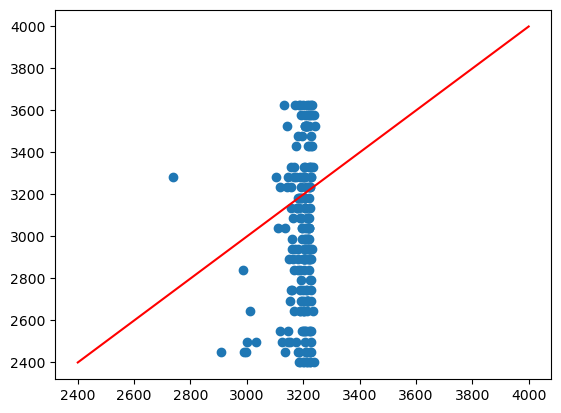

In [82]:
ops, outputst, targetst = validation(epoch, training_loader)
ops, outputs, targets = validation(epoch, testing_loader)

plt.plot(outputs, targets, 'o') 

plt.plot([2400, 4000], [2400, 4000], 'r-')

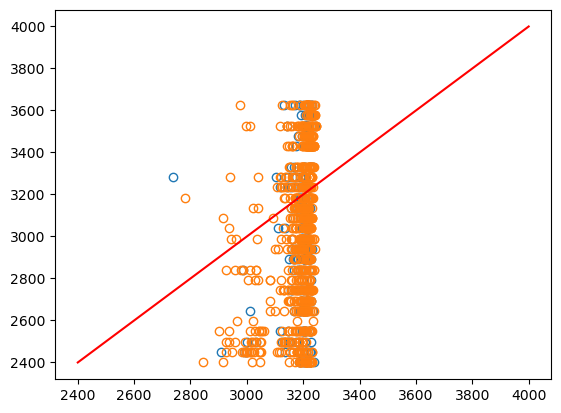

In [84]:

plt.plot(outputs, targets, 'o', fillstyle='none') 
plt.plot(outputst, targetst, 'o', fillstyle='none') 

plt.plot([2400, 4000], [2400, 4000], 'r-')

In [69]:
ops, outputs, targets = validation(epoch)
np.array(outputs).shape, np.array(targets).shape

/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


((200,), (200,))

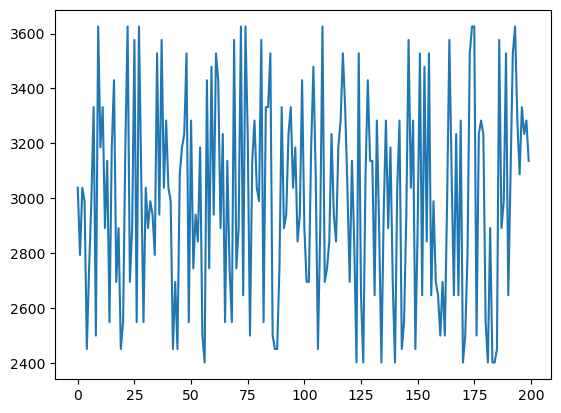

In [46]:
plt.plot(targets)

## Tokenizer

In [15]:

checkpoint = "distilbert-base-cased"
#checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

prod_encoded = prod.map(tokenize_function, batched=True, batch_size=None)
prod_encoded

Map:   0%|          | 0/68348 [00:00<?, ? examples/s]

Map:   0%|          | 0/6834 [00:00<?, ? examples/s]

Map:   0%|          | 0/761 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'lab_0', 'lab_1', 'lab_2', 'lab_3', 'lab_4', 'lab_5', 'base_label', 'orig_lab', 'input_ids', 'attention_mask'],
        num_rows: 68348
    })
    test: Dataset({
        features: ['text', 'label', 'lab_0', 'lab_1', 'lab_2', 'lab_3', 'lab_4', 'lab_5', 'base_label', 'orig_lab', 'input_ids', 'attention_mask'],
        num_rows: 6834
    })
    validation: Dataset({
        features: ['text', 'label', 'lab_0', 'lab_1', 'lab_2', 'lab_3', 'lab_4', 'lab_5', 'base_label', 'orig_lab', 'input_ids', 'attention_mask'],
        num_rows: 761
    })
})

In [16]:
print(prod_encoded['train'][0])
num_labels = df_csv.base_label.max()+1


{'text': 'New Belgium Brewing Fat Tire Ale12 fl oz', 'label': 2401, 'lab_0': 0, 'lab_1': 1, 'lab_2': 0, 'lab_3': 0, 'lab_4': 0, 'lab_5': 0, 'base_label': 2401, 'orig_lab': 'alcohol/beer/ales/amber red ale', 'input_ids': [101, 1203, 4990, 139, 11899, 1158, 13723, 157, 5817, 2586, 1162, 11964, 22593, 24919, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


## Tiny prod

In [26]:

# [x for x in dir(transformers) if re.search(r'^AutoModel', x)]
[x for x in dir(transformers) if re.search(r'Bert', x)]


['BertConfig',
 'BertForMaskedLM',
 'BertForMultipleChoice',
 'BertForNextSentencePrediction',
 'BertForPreTraining',
 'BertForQuestionAnswering',
 'BertForSequenceClassification',
 'BertForTokenClassification',
 'BertGenerationConfig',
 'BertGenerationDecoder',
 'BertGenerationEncoder',
 'BertGenerationPreTrainedModel',
 'BertGenerationTokenizer',
 'BertJapaneseTokenizer',
 'BertLMHeadModel',
 'BertLayer',
 'BertModel',
 'BertPreTrainedModel',
 'BertTokenizer',
 'BertTokenizerFast',
 'BertweetTokenizer',
 'ConvBertConfig',
 'ConvBertForMaskedLM',
 'ConvBertForMultipleChoice',
 'ConvBertForQuestionAnswering',
 'ConvBertForSequenceClassification',
 'ConvBertForTokenClassification',
 'ConvBertLayer',
 'ConvBertModel',
 'ConvBertPreTrainedModel',
 'ConvBertTokenizer',
 'ConvBertTokenizerFast',
 'DistilBertConfig',
 'DistilBertForMaskedLM',
 'DistilBertForMultipleChoice',
 'DistilBertForQuestionAnswering',
 'DistilBertForSequenceClassification',
 'DistilBertForTokenClassification',
 'Disti

In [18]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_mps = torch.backends.mps.is_available()
device = torch.device("mps" if use_mps else "cpu")

# num_labels = 100000
model = (AutoModelForSequenceClassification
         .from_pretrained(checkpoint, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
tiny_prod = DatasetDict()
tiny_prod['train'] = prod['train'].shuffle(seed=1).select(range(50))
tiny_prod['validation'] = prod['validation'].shuffle(seed=1).select(range(10))
tiny_prod['test'] = prod['test'].shuffle(seed=1).select(range(10))

tiny_prod_encoded = tiny_prod.map(tokenize_function, batched=True, batch_size=None)
tiny_prod_encoded

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'lab_0', 'lab_1', 'lab_2', 'lab_3', 'lab_4', 'lab_5', 'base_label', 'orig_lab', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
    validation: Dataset({
        features: ['text', 'label', 'lab_0', 'lab_1', 'lab_2', 'lab_3', 'lab_4', 'lab_5', 'base_label', 'orig_lab', 'input_ids', 'attention_mask'],
        num_rows: 10
    })
    test: Dataset({
        features: ['text', 'label', 'lab_0', 'lab_1', 'lab_2', 'lab_3', 'lab_4', 'lab_5', 'base_label', 'orig_lab', 'input_ids', 'attention_mask'],
        num_rows: 10
    })
})

In [20]:

batch_size = 8
logging_steps = len(tiny_prod_encoded["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-tiny-prod"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch'
                                  )
# training_args

/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:

torch.cuda.empty_cache()

trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=tiny_prod_encoded["train"],
                  eval_dataset=tiny_prod_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

  0%|          | 0/14 [00:00<?, ?it/s]

{'loss': 10.9523, 'grad_norm': 3.740016460418701, 'learning_rate': 1.1428571428571429e-05, 'epoch': 0.86}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 10.98707389831543, 'eval_runtime': 0.1271, 'eval_samples_per_second': 78.706, 'eval_steps_per_second': 15.741, 'epoch': 1.0}
{'loss': 10.9532, 'grad_norm': 3.8110268115997314, 'learning_rate': 2.8571428571428573e-06, 'epoch': 1.71}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 10.984347343444824, 'eval_runtime': 0.0618, 'eval_samples_per_second': 161.697, 'eval_steps_per_second': 32.339, 'epoch': 2.0}
{'train_runtime': 2.7223, 'train_samples_per_second': 36.734, 'train_steps_per_second': 5.143, 'train_loss': 10.934354509626116, 'epoch': 2.0}


In [22]:
preds = trainer.predict(tiny_prod_encoded['test'])
preds.label_ids, preds.predictions.argmax(axis=-1)


  0%|          | 0/2 [00:00<?, ?it/s]

(array([51653, 45521, 14798, 47733, 55804, 39837, 54341, 42532, 51639,
        55916]),
 array([28786, 28786, 28786, 28786, 28786, 28786, 48069, 28786, 28786,
        28786]))

In [23]:
accuracy_score(preds.label_ids, preds.predictions.argmax(axis=-1))

0.0

In [24]:
def get_accuracy(preds):
  predictions = preds.predictions.argmax(axis=-1)
  labels = preds.label_ids
  accuracy = accuracy_score(preds.label_ids, preds.predictions.argmax(axis=-1))
  return {'accuracy': accuracy}


In [25]:
torch.cuda.empty_cache()

trainer = Trainer(model=model,
                  compute_metrics=get_accuracy,
                  args=training_args,
                  train_dataset=tiny_prod_encoded["train"],
                  eval_dataset=tiny_prod_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

  0%|          | 0/14 [00:00<?, ?it/s]

{'loss': 10.8553, 'grad_norm': 3.9065370559692383, 'learning_rate': 1.1428571428571429e-05, 'epoch': 0.86}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 10.970666885375977, 'eval_accuracy': 0.0, 'eval_runtime': 0.0549, 'eval_samples_per_second': 182.056, 'eval_steps_per_second': 36.411, 'epoch': 1.0}
{'loss': 10.8639, 'grad_norm': 4.338132858276367, 'learning_rate': 2.8571428571428573e-06, 'epoch': 1.71}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 10.961466789245605, 'eval_accuracy': 0.0, 'eval_runtime': 0.0449, 'eval_samples_per_second': 222.831, 'eval_steps_per_second': 44.566, 'epoch': 2.0}
{'train_runtime': 1.8067, 'train_samples_per_second': 55.35, 'train_steps_per_second': 7.749, 'train_loss': 10.840790339878627, 'epoch': 2.0}


In [27]:
model = transformers.BertModel.from_pretrained("bert-base-cased")


TypeError: BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): BertOutput(
          (dense): Linear(in_features=3072, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (pooler): BertPooler(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
  )
) argument after ** must be a mapping, not Dataset

## Training run

In [25]:
batch_size = 8
logging_steps = len(prod_encoded["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-products_ep6"
# model_name = f"{checkpoint}-finetuned-tiny-prod"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=7,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch'
                                  )

/Applications/conda/miniconda3/envs/test_burnt/lib/python3.9/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
torch.cuda.empty_cache()

trainer = Trainer(model=model,
                  args=training_args,
                #   compute_metrics=get_accuracy,
                  train_dataset=prod_encoded["train"],
                  eval_dataset=prod_encoded["validation"],
                  tokenizer=tokenizer)
# trainer = Trainer(model=model,
#                   args=training_args,
#                   compute_metrics=get_accuracy,
#                   train_dataset=tiny_prod_encoded["train"],
#                   eval_dataset=tiny_prod_encoded["validation"],
#                   tokenizer=tokenizer)


trainer.train();

  0%|          | 0/59808 [00:00<?, ?it/s]

{'loss': 5.8162, 'grad_norm': 16.882169723510742, 'learning_rate': 1.7143191546281435e-05, 'epoch': 1.0}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 3.3748512268066406, 'eval_runtime': 2.972, 'eval_samples_per_second': 256.054, 'eval_steps_per_second': 32.301, 'epoch': 1.0}
{'loss': 2.2963, 'grad_norm': 20.125181198120117, 'learning_rate': 1.428638309256287e-05, 'epoch': 2.0}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 1.8159546852111816, 'eval_runtime': 2.0002, 'eval_samples_per_second': 380.468, 'eval_steps_per_second': 47.996, 'epoch': 2.0}
{'loss': 1.3717, 'grad_norm': 20.841697692871094, 'learning_rate': 1.1429574638844302e-05, 'epoch': 3.0}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 1.519281029701233, 'eval_runtime': 2.0114, 'eval_samples_per_second': 378.34, 'eval_steps_per_second': 47.728, 'epoch': 3.0}
{'loss': 1.0039, 'grad_norm': 13.465274810791016, 'learning_rate': 8.572766185125736e-06, 'epoch': 4.0}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 1.3804091215133667, 'eval_runtime': 2.0719, 'eval_samples_per_second': 367.301, 'eval_steps_per_second': 46.335, 'epoch': 4.0}
{'loss': 0.7852, 'grad_norm': 26.807180404663086, 'learning_rate': 5.7159577314071705e-06, 'epoch': 5.0}


  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 1.3703014850616455, 'eval_runtime': 1.9849, 'eval_samples_per_second': 383.397, 'eval_steps_per_second': 48.365, 'epoch': 5.0}


RuntimeError: [enforce fail at inline_container.cc:595] . unexpected pos 150444224 vs 150444116

In [28]:
trainer.save_model()

In [29]:


trainer.evaluate()

  0%|          | 0/96 [00:00<?, ?it/s]

{'eval_loss': 1.3548964262008667, 'eval_runtime': 2.1193, 'eval_samples_per_second': 359.081, 'eval_steps_per_second': 45.298, 'epoch': 5.33}


{'eval_loss': 1.3548964262008667,
 'eval_runtime': 2.1193,
 'eval_samples_per_second': 359.081,
 'eval_steps_per_second': 45.298,
 'epoch': 5.325374531835206}

In [30]:
model_name

'distilbert-base-cased-finetuned-products_ep6'

In [73]:
prod_encoded['test'][0]['text']

'Classic Touch 3 Leaf Dish, Gold1 each'

In [31]:
from transformers import pipeline
classifier = pipeline('text-classification', model=model_name)
# classifier = pipeline('text-classification', model=model)
classifier(prod_encoded['test'][0]['text']), prod_encoded['test'][0]['label']

([{'label': 'LABEL_2401', 'score': 0.4738472104072571}], 2401)

In [35]:
torch.cuda.empty_cache()
preds = trainer.predict(prod_encoded['test'].select(range(380)))


  0%|          | 0/48 [00:00<?, ?it/s]

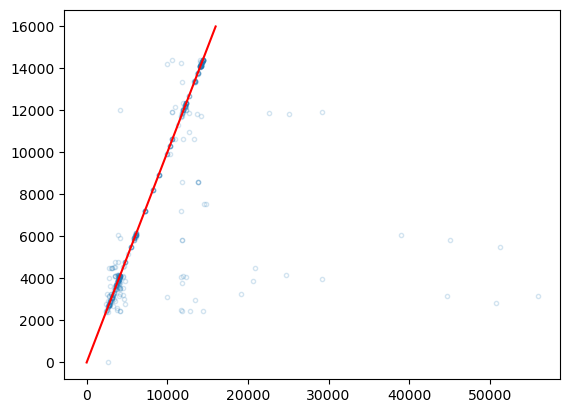

In [38]:
plt.plot(preds.predictions.argmax(axis=-1), preds.label_ids, '.', alpha = .2, fillstyle = 'none')
plt.plot([0, 16000], [0, 16000], 'r-')

In [322]:
trainer.push_to_hub("amirkazemim/distilbert_base_cased_finetuned_products")

CommitInfo(commit_url='https://huggingface.co/amirkazemim/distilbert-base-cased-finetuned-products/commit/4141c89c50f6b08ab95ffd24aa3e507c6327c631', commit_message='amirkazemim/distilbert_base_cased_finetuned_products', commit_description='', oid='4141c89c50f6b08ab95ffd24aa3e507c6327c631', pr_url=None, pr_revision=None, pr_num=None)

In [323]:
unq_ids, unq_cnt = np.unique(preds.label_ids, return_counts=True)
pred_labs = preds.predictions.argmax(axis=-1)

In [324]:
unq_ids[0], unq_cnt[0]

(22050, 2)

In [326]:
for ii, (iu, uc) in enumerate(zip(unq_ids, unq_cnt)):
    pred_sel = pred_labs[np.where(preds.label_ids == iu)[0]]
    prc_u = np.sum(pred_sel == iu)
    if uc>1:
        print(f'{ii}-{iu}: {uc}, {prc_u}, {prc_u/uc:.2f}')

0-22050: 2, 0, 0.00
2-22295: 4, 3, 0.75
3-22344: 2, 2, 1.00
4-22393: 2, 0, 0.00
5-22442: 2, 1, 0.50
6-22540: 5, 2, 0.40
8-22638: 2, 1, 0.50
9-22687: 2, 2, 1.00
10-22736: 3, 0, 0.00
13-22883: 2, 1, 0.50
18-23177: 2, 0, 0.00
20-23275: 3, 2, 0.67
22-23471: 4, 2, 0.50
23-23520: 2, 2, 1.00
24-23569: 3, 3, 1.00
26-23667: 7, 6, 0.86
27-23716: 5, 2, 0.40
29-24108: 4, 0, 0.00
31-24353: 2, 2, 1.00
33-25039: 4, 1, 0.25
34-25431: 3, 3, 1.00
35-25529: 2, 2, 1.00
38-25676: 4, 2, 0.50
40-25774: 2, 2, 1.00
41-26754: 4, 4, 1.00
43-27783: 2, 2, 1.00
44-28126: 3, 0, 0.00
45-28469: 4, 4, 1.00
46-28812: 2, 1, 0.50
47-29204: 2, 0, 0.00
48-29253: 2, 2, 1.00
49-29302: 4, 4, 1.00
50-29547: 2, 2, 1.00
51-29645: 5, 4, 0.80
53-29743: 3, 2, 0.67
54-29841: 3, 3, 1.00
55-29890: 2, 2, 1.00
57-30086: 4, 2, 0.50
58-30135: 2, 1, 0.50
59-30184: 9, 4, 0.44
61-30968: 2, 2, 1.00
62-31017: 2, 2, 1.00
64-31213: 2, 1, 0.50
65-31311: 3, 2, 0.67
66-31360: 2, 1, 0.50
67-31409: 7, 0, 0.00
68-31458: 3, 0, 0.00
69-31507: 5, 3, 0.60


In [100]:
ii=67
iu, uc = unq_ids[ii], unq_cnt[ii]
pred_sel = pred_labs[np.where(preds.label_ids == iu)[0]]
prc_u = np.sum(pred_sel == iu)
print(pred_sel)
if uc>10:
    print(f'{iu}: {uc}, {prc_u}, {prc_u/uc:.2f}')

[9469 9469 9943 9469 9737 9469 9469 9932 9929 9943 9943 9470 9666 9932
 9943 9932 9469 9932 9943 9943 9469 9929 9943 9943 9943 9469 9469 9469
 9469 9933 9943 9943 9943 9943 9943 9943 9943 9929 9469 9943 9943 9929
 9943 9943 9929 9943 9469 9469 9469 9929 9469 9469 9469 9943 9929 9929
 9469 9469 9943 9943 9737 9469 9943 9470 9470 9535 9667 9932 9943 9666
 9943 9667 9943 9469 9929 9929 9943 9943 9943 9996 9932 9535]
9469: 82, 22, 0.27


In [78]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

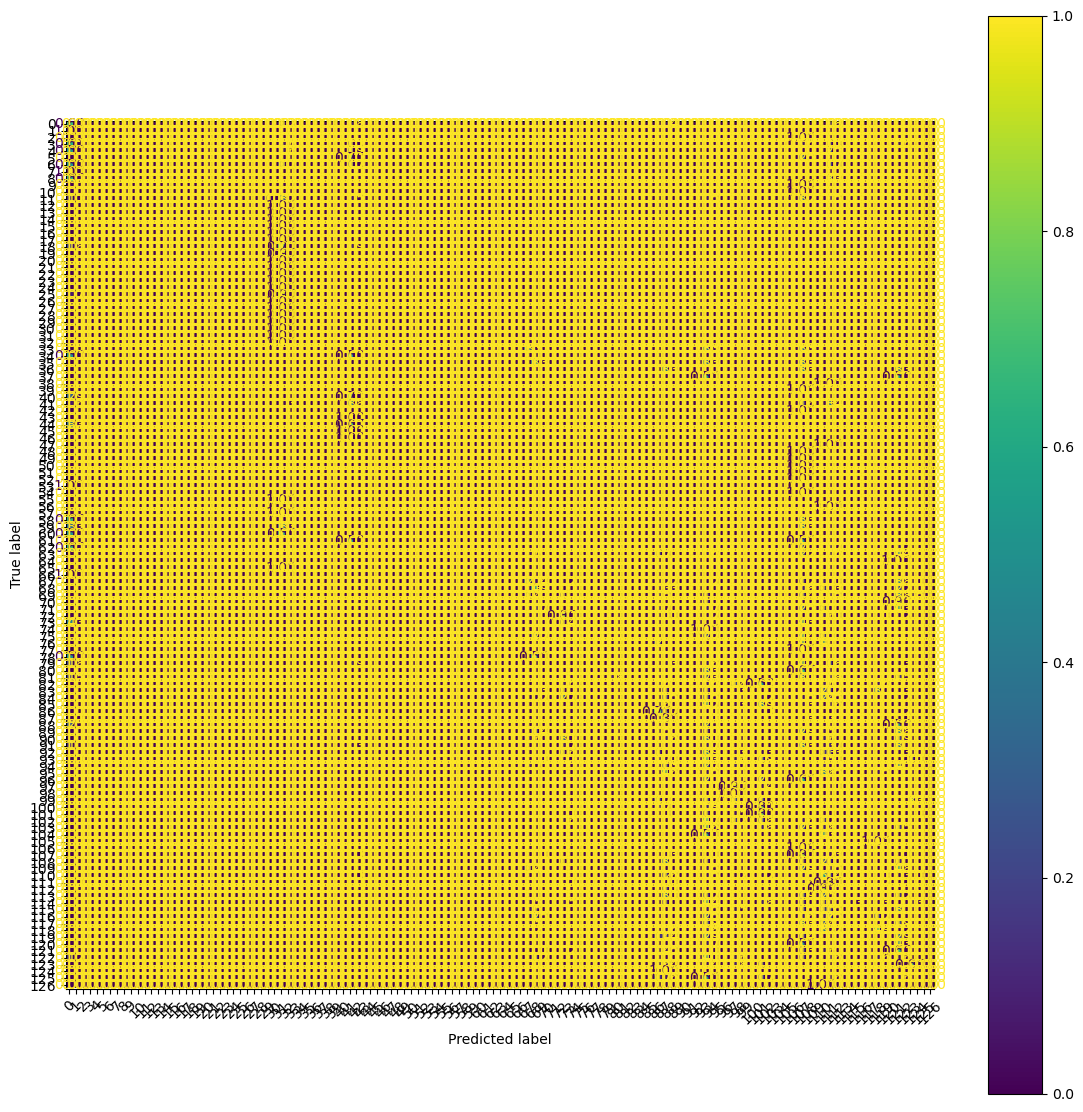

In [79]:
fig, ax = plt.subplots(figsize=(14, 14)) 

cm = confusion_matrix(y_true=preds.label_ids, y_pred=preds.predictions.argmax(axis=-1), normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(ax=ax, cmap='viridis', xticks_rotation=45, values_format='.2f') 


In [352]:
for ids in range(len(prod_encoded['test'])):
    print(prod_encoded['test'][ids]['label'], classifier(prod_encoded['test'][ids]['text'])[0]['label'])

65 LABEL_65
65 LABEL_68
65 LABEL_65
65 LABEL_268
65 LABEL_65
65 LABEL_65
65 LABEL_65
65 LABEL_65
65 LABEL_68
65 LABEL_65
65 LABEL_65
65 LABEL_68
65 LABEL_68
65 LABEL_65
65 LABEL_68
65 LABEL_65
65 LABEL_65
66 LABEL_65
66 LABEL_65
65 LABEL_68
65 LABEL_65
65 LABEL_215
65 LABEL_68
65 LABEL_215
65 LABEL_68
65 LABEL_65
65 LABEL_268
65 LABEL_268
65 LABEL_65
65 LABEL_65
65 LABEL_65
65 LABEL_68
65 LABEL_65
65 LABEL_65
65 LABEL_65
65 LABEL_65
65 LABEL_68
65 LABEL_65
65 LABEL_65
65 LABEL_270
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_65
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_65
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_65
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_65
68 LABEL_68
68 LABEL_68
68 LABEL_68
68 LABEL_68
71 LABEL_65
71 LABEL_65
71 LABEL_65
71 LABEL_65
71 LABEL_65
71 LABEL_68
67 LABEL_68
69 LABEL_68
69 LABEL_68
69 LABEL_69
69 LABEL_65
69 LABEL_65
69 LABEL_65
69 LABEL_65
69 LABEL_69
69 LABEL_65
69 LABEL_68
69 LABEL_65
69 LABEL_268
69 LABEL_

KeyboardInterrupt: 